## Imports

In [831]:
import kagglehub
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
from tqdm.notebook import tqdm
import uuid
import shutil

## Data Loading and Visualization

Number of TRAIN Normal images: 1341
Number of TRAIN Pneumonia images: 3875
Number of VALIDATION Normal images: 8
Number of VALIDATION Pneumonia images: 8
Number of TEST Normal images: 234
Number of TEST Pneumonia images: 390


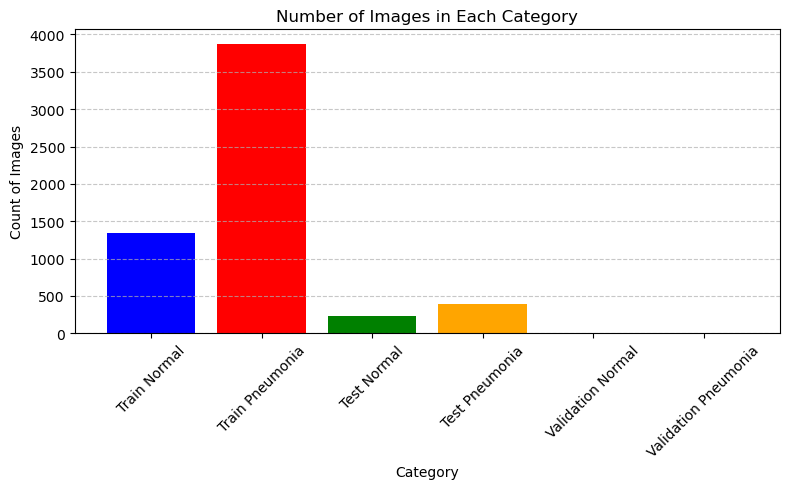

In [ ]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# Path to dataset directory
dataset_path = os.path.join(path, "chest_xray")

# Directories for training data
train_normal_dir = os.path.join(dataset_path, 'train', 'NORMAL')
train_pneumonia_dir = os.path.join(dataset_path, 'train', 'PNEUMONIA')

# Directories for training data
val_normal_dir = os.path.join(dataset_path, 'val', 'NORMAL')
val_pneumonia_dir = os.path.join(dataset_path, 'val', 'PNEUMONIA')

# Directories for testing data
test_normal_dir = os.path.join(dataset_path, 'test', 'NORMAL')
test_pneumonia_dir = os.path.join(dataset_path, 'test', 'PNEUMONIA')

def xray_data_distribution(dataset_path):

    # Count the images
    train_normal_count = len(os.listdir(train_normal_dir))
    train_pneumonia_count = len(os.listdir(train_pneumonia_dir))
    val_normal_count = len(os.listdir(val_normal_dir))
    val_pneumonia_count = len(os.listdir(val_pneumonia_dir))
    test_normal_count = len(os.listdir(test_normal_dir))
    test_pneumonia_count = len(os.listdir(test_pneumonia_dir))

    # Print the counts
    print("Number of TRAIN Normal images:", train_normal_count)
    print("Number of TRAIN Pneumonia images:", train_pneumonia_count)
    print("Number of VALIDATION Normal images:", val_normal_count)
    print("Number of VALIDATION Pneumonia images:", val_pneumonia_count)
    print("Number of TEST Normal images:", test_normal_count)
    print("Number of TEST Pneumonia images:", test_pneumonia_count)

    # Prepare data for bar chart
    labels = [
        'Train Normal', 'Train Pneumonia', 
        'Test Normal', 'Test Pneumonia',
        'Validation Normal', 'Validation Pneumonia' 
    ]
    counts = [
        train_normal_count, train_pneumonia_count, 
        test_normal_count, test_pneumonia_count,
        val_normal_count, val_pneumonia_count
    ]

    # Create a bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(labels, counts, color=['blue', 'red', 'green', 'orange', 'purple', 'black'])
    plt.title('Number of Images in Each Category')
    plt.xlabel('Category')
    plt.ylabel('Count of Images')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

xray_data_distribution(dataset_path)


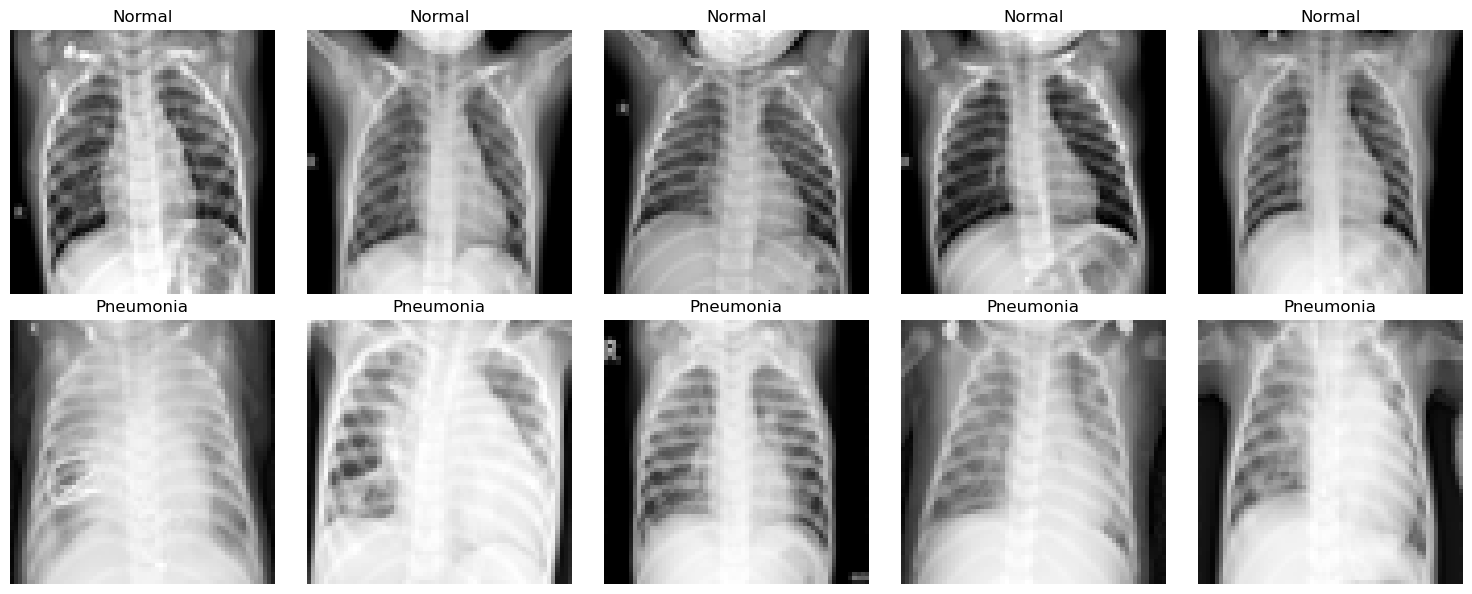

In [ ]:
# Get a list of image file names from each class
normal_images = [os.path.join(train_normal_dir, f) for f in os.listdir(train_normal_dir) if f.lower().endswith('.jpeg')]
pneumonia_images = [os.path.join(train_pneumonia_dir, f) for f in os.listdir(train_pneumonia_dir) if f.lower().endswith('.jpeg')]

# Select the first 5 images from each class
normal_examples = normal_images[:5]
pneumonia_examples = pneumonia_images[:5]

# Desired size
target_size = (64, 64)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Plot the normal images
for i, img_path in enumerate(normal_examples):
    img = Image.open(img_path)
    img = img.resize(target_size)  # Resize to 64x64
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Normal")

# Plotting the pneumonia images
for i, img_path in enumerate(pneumonia_examples):
    img = Image.open(img_path)
    img = img.resize(target_size)  # Resize to 64x64
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Pneumonia")

plt.tight_layout()
plt.show()

## Partially Pre-Trained Convolutional Neural Network

In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "val"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Leveraging pretrained model to initialize conv1 weights
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = SimpleCNN()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def evaluate_model(model, loader):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            correct += (outputs.round() == targets).sum().item()
            total += targets.size(0)
    avg_loss = test_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

def train(model, train_loader, val_loader, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Track the best validation accuracy and save the corresponding model state
    best_val_acc = 0.0
    best_model_path = "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as progress:
            for inputs, targets in progress:
                inputs, targets = inputs.to(device), targets.to(device).float()
                optimizer.zero_grad()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                correct += (outputs.round() == targets).sum().item()
                total += targets.size(0)

                # Update tqdm description dynamically
                progress.set_postfix({"Train Loss": running_loss / (len(progress) + 1)})

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Evaluate on validation set
        val_loss, val_acc = evaluate_model(model, val_loader)

        # Save model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Validation accuracy improved to {best_val_acc:.4f}, model saved!")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    
    # Plot training and validation losses
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot training and validation accuracies
    plt.subplot(1,2,2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Acc')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Acc')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return model

# Restore the best model
def revert_to_best_model(model, best_model_path):
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    model = model.to(device)
    print("Reverted to the best model based on validation accuracy.")
    return model

## Training and Evaluation

Epoch 1/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Validation accuracy improved to 0.6875, model saved!
Epoch 1/10 Train Loss: 0.2424, Train Acc: 0.8915 Val Loss: 0.8053, Val Acc: 0.6875


Epoch 2/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 2/10 Train Loss: 0.1168, Train Acc: 0.9553 Val Loss: 1.6332, Val Acc: 0.5000


Epoch 3/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Validation accuracy improved to 0.7500, model saved!
Epoch 3/10 Train Loss: 0.1053, Train Acc: 0.9603 Val Loss: 0.4302, Val Acc: 0.7500


Epoch 4/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 4/10 Train Loss: 0.0846, Train Acc: 0.9678 Val Loss: 0.4536, Val Acc: 0.7500


Epoch 5/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Validation accuracy improved to 0.8750, model saved!
Epoch 5/10 Train Loss: 0.0793, Train Acc: 0.9686 Val Loss: 0.2738, Val Acc: 0.8750


Epoch 6/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 6/10 Train Loss: 0.0769, Train Acc: 0.9734 Val Loss: 0.2772, Val Acc: 0.8125


Epoch 7/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 7/10 Train Loss: 0.0535, Train Acc: 0.9831 Val Loss: 0.2839, Val Acc: 0.8125


Epoch 8/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 8/10 Train Loss: 0.0633, Train Acc: 0.9762 Val Loss: 0.2838, Val Acc: 0.8750


Epoch 9/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 9/10 Train Loss: 0.0503, Train Acc: 0.9808 Val Loss: 0.8499, Val Acc: 0.6250


Epoch 10/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 10/10 Train Loss: 0.0444, Train Acc: 0.9822 Val Loss: 0.5781, Val Acc: 0.6875
Best Validation Accuracy: 0.8750


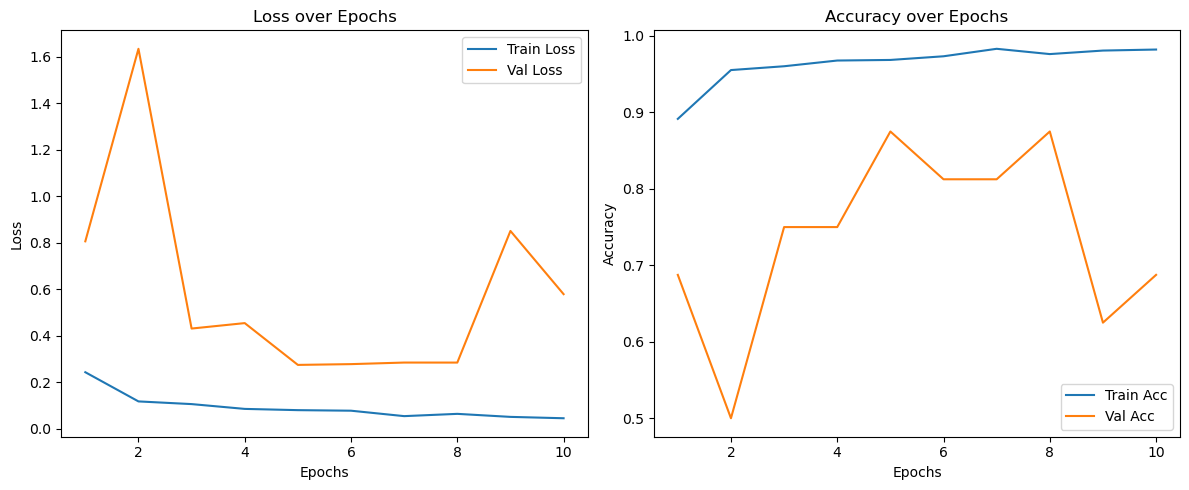

Test Loss: 1.1188, Test Accuracy: 0.7340
Reverted to the best model based on validation accuracy.
Test Loss: 0.5257, Test Accuracy: 0.8269


In [43]:
# Partial Pretraining:
pretrained_model = resnet18(weights=ResNet18_Weights.DEFAULT)
pretrained_weights = pretrained_model.conv1.weight.data  # shape: [64, 3, 7, 7]

with torch.no_grad():
    # first 16 filters
    pretrained_16 = pretrained_weights[:16]  # shape: [16, 3, 7, 7]

    # average across the 3 channels
    averaged = pretrained_16.mean(dim=1, keepdim=True)  # shape: [16, 1, 7, 7]

    # extract center 3x3
    center_3x3 = averaged[:, :, 2:5, 2:5]  # shape: [16, 1, 3, 3]

    # Assign to our conv1 weights
    model.conv1.weight.data = center_3x3

# Move model to device
model = model.to(device)

# Train the model
num_epochs = 10
model = train(model, train_loader, val_loader, num_epochs)

# Evaluate on test set
test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Revert model to state with best saved parameters
model = revert_to_best_model(model, "best_model.pth")

# Re-evaluate on test set
test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

## Generative Adversarial Network

In [ ]:
# Hyperparameters
latent_dim = 100
batch_size = 64
image_size = 64
num_epochs = 100
learning_rate = 0.0001  # WGAN-GP uses lower lr
beta1 = 0.0
beta2 = 0.9
channels_img = 1
lambda_gp = 10          # Gradient penalty coefficient
critic_iters = 5        # Number of critic updates per generator update

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Creating new directory for GAN training
gan_train_dir = os.path.join(dataset_path, "GAN_train")
os.makedirs(gan_train_dir, exist_ok=True)

normals_dir = os.path.join(dataset_path, "train", 'NORMAL')
shutil.copytree(normals_dir, os.path.join(gan_train_dir, 'NORMAL'), dirs_exist_ok=True)
dataset = torchvision.datasets.ImageFolder(root=gan_train_dir, transform=transform)
fake_normal_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [804]:
# Generator (DCGAN-style architecture)
class Generator(nn.Module):
    def __init__(self, latent_dim, channels_img, features_g=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, features_g*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g*8, features_g*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g*4, features_g*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g*2, features_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g, channels_img, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.main(x)

# Critic (modified Discriminator)
class Critic(nn.Module):
    def __init__(self, channels_img, features_d=64):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d, features_d*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(features_d*2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d*2, features_d*4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(features_d*4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d*4, features_d*8, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(features_d*8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d*8, 1, 4, 1, 0, bias=False)
        )
    def forward(self, x):
        return self.main(x)

G = Generator(latent_dim, channels_img).to(device)
D = Critic(channels_img).to(device)

def weights_init(m):
    if isinstance(m, (nn.ConvTranspose2d, nn.Conv2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if isinstance(m, (nn.BatchNorm2d, nn.InstanceNorm2d)):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G.apply(weights_init)
D.apply(weights_init)

optimizerG = optim.Adam(G.parameters(), lr=learning_rate, betas=(beta1, beta2))
optimizerD = optim.Adam(D.parameters(), lr=learning_rate, betas=(beta1, beta2))

def gradient_penalty(critic, real, fake, device):
    batch_size, c, h, w = real.shape
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device, requires_grad=True)
    interpolated = epsilon * real + (1 - epsilon) * fake
    mixed_scores = critic(interpolated)
    grad = torch.autograd.grad(
        inputs=interpolated,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    grad = grad.view(grad.size(0), -1)
    gp = torch.mean((grad.norm(2, dim=1) - 1)**2)
    return gp

## Training

In [805]:
G.train()
D.train()

for epoch in range(num_epochs):
    with tqdm(fake_normal_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as progress:
        for batch_idx, (real, _) in enumerate(progress):
            real = real.to(device)
            batch_size = real.size(0)

            # Train Critic multiple times
            for _ in range(critic_iters):
                noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
                fake = G(noise)

                D.zero_grad()
                critic_real = D(real).view(-1)
                critic_fake = D(fake.detach()).view(-1)
                gp = gradient_penalty(D, real, fake.detach(), device)
                lossD = -(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp * gp
                lossD.backward()
                optimizerD.step()

            # Train Generator
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake = G(noise)
            gen_fake = D(fake).view(-1)
            lossG = -torch.mean(gen_fake)

            G.zero_grad()
            lossG.backward()
            optimizerG.step()

            progress.set_postfix({"Critic Loss": lossD.item(), "Gen Loss": lossG.item()})


Epoch [1/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [2/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [3/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [4/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [5/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [6/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [7/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [8/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [9/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [10/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [11/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [12/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [13/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [14/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [15/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [16/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [17/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [18/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [19/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [20/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [21/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [22/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [23/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [24/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [25/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [26/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [27/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [28/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [29/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [30/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [31/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [32/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [33/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [34/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [35/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [36/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [37/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [38/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [39/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [40/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [41/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [42/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [43/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [44/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [45/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [46/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [47/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [48/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [49/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [50/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [51/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [52/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [53/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [54/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [55/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [56/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [57/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [58/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [59/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [60/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [61/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [62/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [63/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [64/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [65/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [66/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [67/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [68/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [69/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [70/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [71/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [72/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [73/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [74/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [75/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [76/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [77/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [78/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [79/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [80/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [81/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [82/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [83/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [84/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [85/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [86/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [87/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [88/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [89/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [90/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [91/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [92/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [93/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [94/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [95/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [96/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [97/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [98/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [99/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

Epoch [100/100]:   0%|          | 0/21 [00:00<?, ?batch/s]

## Generating New Samples

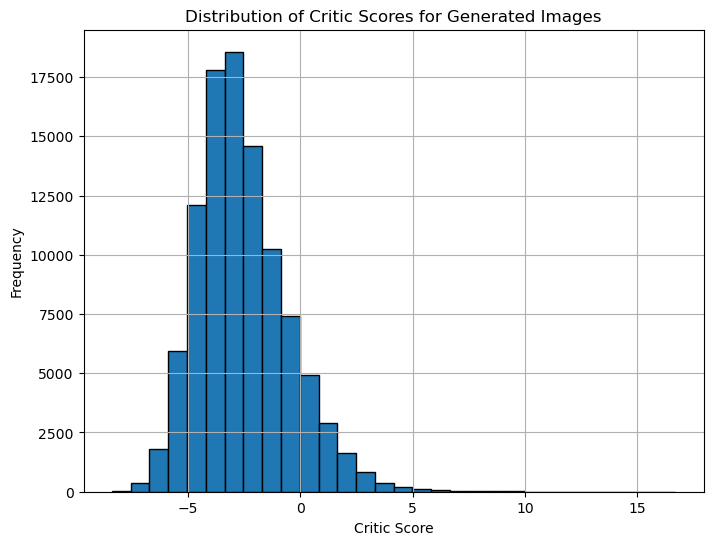

In [822]:
G.eval()
D.eval()

num_samples = 100000
scores = []

with torch.no_grad():
    for _ in range(num_samples):
        noise = torch.randn(1, latent_dim, 1, 1, device=device)
        fake_image = G(noise)  # Fake image in [-1,1]
        score = D(fake_image).item()
        scores.append(score)

# Plot the histogram of critic scores
plt.figure(figsize=(8,6))
plt.hist(scores, bins=30, edgecolor='black')
plt.title("Distribution of Critic Scores for Generated Images")
plt.xlabel("Critic Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
# Paths to directories
train_normal_dir = os.path.join(dataset_path, "train", "NORMAL")
fake_normals_dir = os.path.join(dataset_path, "fake_normals")
os.makedirs(fake_normals_dir, exist_ok=True)

G.eval()
D.eval()

# Generate 500 synthetic normal images
num_to_generate = 500
generated_count = 0

threshold = 10.0  # Only keep images that have a critic score above 10.0
with tqdm(total=num_to_generate, desc="Generating Images", unit="image") as pbar:
    with torch.no_grad():
        while generated_count < num_to_generate:
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = G(noise)
            # retrieve critic score
            outputs = D(fake_images).view(-1)

            # Filter out images with scores > threshold
            keep_indices = (outputs > threshold).nonzero(as_tuple=True)[0]
            keep_images = fake_images[keep_indices]

            for img_tensor in keep_images:
                if generated_count >= num_to_generate:
                    break
                # Convert to PIL Image
                img = img_tensor.cpu() * 0.5 + 0.5  # Denormalize
                img = transforms.ToPILImage()(img)

                # Generate a unique filename
                filename = f"gen_{uuid.uuid4().hex}.jpeg"

                # Save the image to both directories
                # img.save(os.path.join(fake_normal_dir, filename))
                img.save(os.path.join(train_normal_dir, filename))
                
                generated_count += 1
                pbar.update(1)

print(f"Generated {generated_count} new 'normal' samples with critic score above {threshold}.")


Generating Images:   0%|          | 0/500 [00:00<?, ?image/s]

Generated 500 new 'normal' samples with critic score above 10.0.


## Viewing Generated Samples

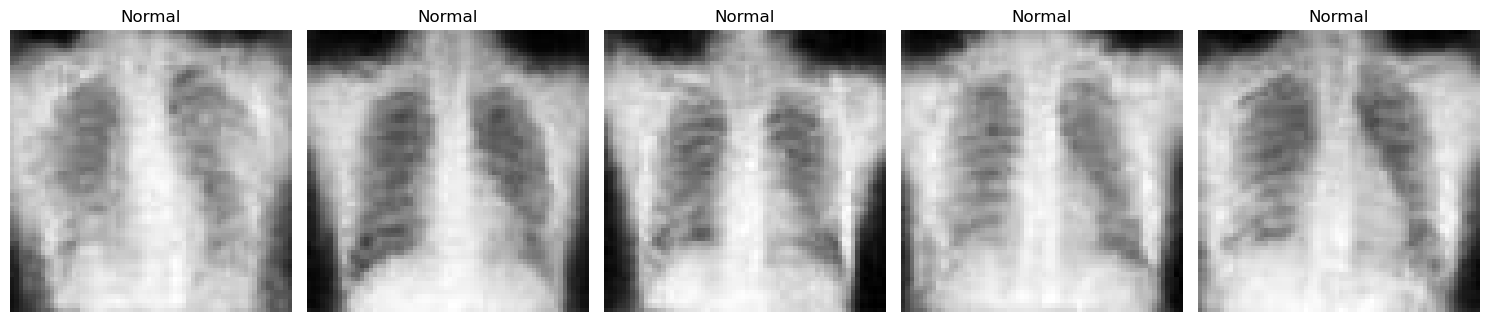

In [828]:
# Get a list of image file names from each class
fake_normals_filenames = [os.path.join(fake_normals_dir, f) for f in os.listdir(fake_normals_dir)]

# Select the first 5 images from each class
fake_samples = fake_normals_filenames[:5]

# Desired size
target_size = (64, 64)

fig, axes = plt.subplots(1, 5, figsize=(15, 6))

# Plot the normal images
for i, img_path in enumerate(fake_samples):
    img = Image.open(img_path)
    img = img.resize(target_size)  # Resize to 64x64
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title("Normal")

plt.tight_layout()
plt.show()

## New Data Distribution

Number of TRAIN Normal images: 1841
Number of TRAIN Pneumonia images: 3875
Number of VALIDATION Normal images: 8
Number of VALIDATION Pneumonia images: 8
Number of TEST Normal images: 234
Number of TEST Pneumonia images: 390


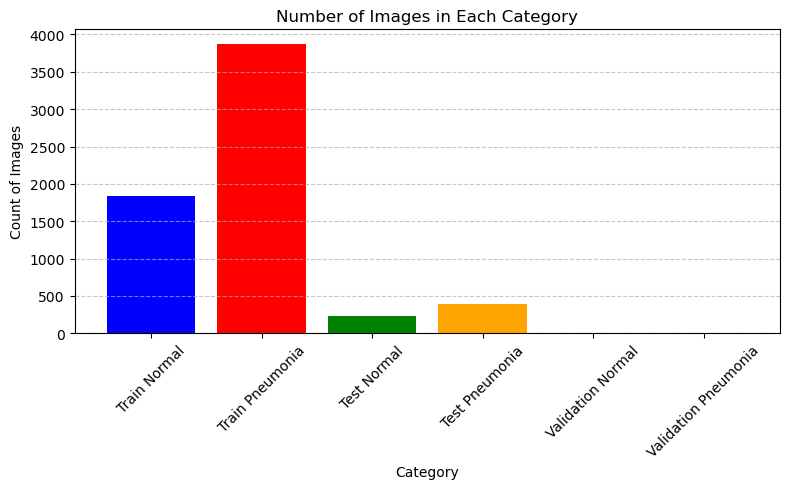

In [838]:
xray_data_distribution(dataset_path)

## Retraining and Evaluating Convolutional Neural Network

Epoch 1/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Validation accuracy improved to 0.6875, model saved!
Epoch 1/10 Train Loss: 0.0644, Train Acc: 0.9753 Val Loss: 0.7022, Val Acc: 0.6875


Epoch 2/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 2/10 Train Loss: 0.0530, Train Acc: 0.9803 Val Loss: 0.6795, Val Acc: 0.6250


Epoch 3/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Validation accuracy improved to 0.7500, model saved!
Epoch 3/10 Train Loss: 0.0510, Train Acc: 0.9803 Val Loss: 0.4848, Val Acc: 0.7500


Epoch 4/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Validation accuracy improved to 0.8750, model saved!
Epoch 4/10 Train Loss: 0.0497, Train Acc: 0.9816 Val Loss: 0.2006, Val Acc: 0.8750


Epoch 5/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 5/10 Train Loss: 0.0486, Train Acc: 0.9801 Val Loss: 0.2747, Val Acc: 0.8750


Epoch 6/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 6/10 Train Loss: 0.0398, Train Acc: 0.9837 Val Loss: 0.6319, Val Acc: 0.6875


Epoch 7/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Validation accuracy improved to 0.9375, model saved!
Epoch 7/10 Train Loss: 0.0250, Train Acc: 0.9916 Val Loss: 0.1691, Val Acc: 0.9375


Epoch 8/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 8/10 Train Loss: 0.0286, Train Acc: 0.9889 Val Loss: 0.4026, Val Acc: 0.7500


Epoch 9/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 9/10 Train Loss: 0.0298, Train Acc: 0.9889 Val Loss: 0.2238, Val Acc: 0.8750


Epoch 10/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 10/10 Train Loss: 0.0176, Train Acc: 0.9937 Val Loss: 0.6252, Val Acc: 0.6875
Best Validation Accuracy: 0.9375


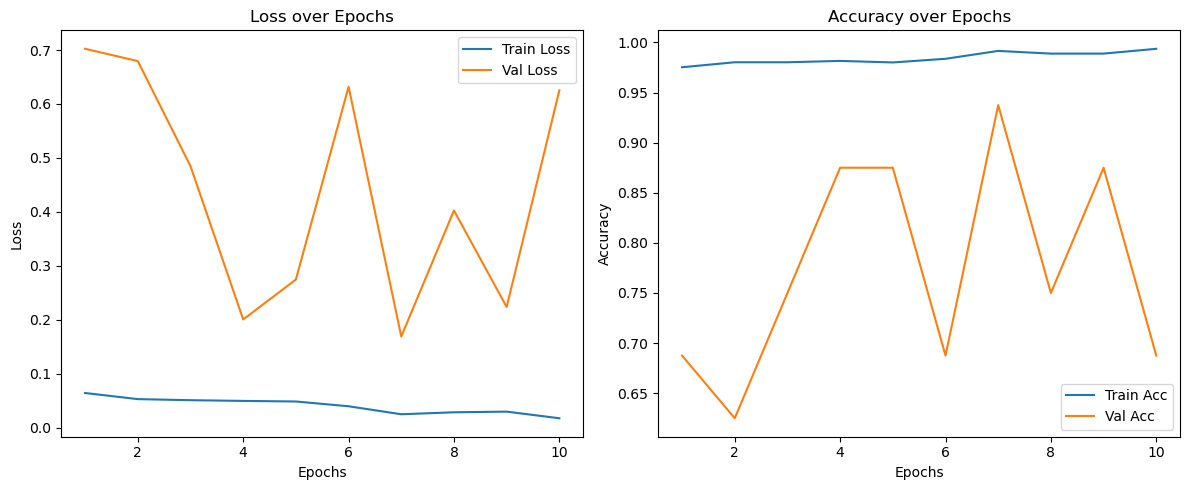

Test Loss: 3.0849, Test Accuracy: 0.7163
Reverted to the best model based on validation accuracy.
Test Loss: 0.9757, Test Accuracy: 0.7981


In [832]:
# Train the model
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
num_epochs = 10
model = train(model, train_loader, val_loader, num_epochs)

# Evaluate on test set
test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Revert model to state with best saved parameters
model = revert_to_best_model(model, "best_model.pth")

# Re-evaluate on test set
test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

## Traditional Augmentation

In [ ]:
from tqdm.notebook import tqdm

# Path to directory containing NORMAL training images
train_normal_dir = os.path.join(dataset_path, "train", "NORMAL")

# Define augmentations
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
])

# Number of augmented versions to create per original image
num_augments_per_image = 2

# List all image files in the directory
image_files = [f for f in os.listdir(train_normal_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Add a progress bar
with tqdm(total=len(image_files) * num_augments_per_image, desc="Augmenting Images", unit="image") as pbar:
    for img_file in image_files:
        img_path = os.path.join(train_normal_dir, img_file)
        # Open the original image
        with Image.open(img_path) as img:
            img = img.convert('RGB')  # ensure image is in RGB mode
            for _ in range(num_augments_per_image):
                # Apply the augmentation transform
                augmented_img = augment_transform(img)
                # Generate a unique filename for the augmented image
                new_filename = f"aug_{uuid.uuid4().hex}.jpeg"
                augmented_img.save(os.path.join(train_normal_dir, new_filename), 'JPEG')
                pbar.update(1)


Augmenting Images:   0%|          | 0/2682 [00:00<?, ?image/s]

## Final Distribution

Number of TRAIN Normal images: 4023
Number of TRAIN Pneumonia images: 3875
Number of VALIDATION Normal images: 8
Number of VALIDATION Pneumonia images: 8
Number of TEST Normal images: 234
Number of TEST Pneumonia images: 390


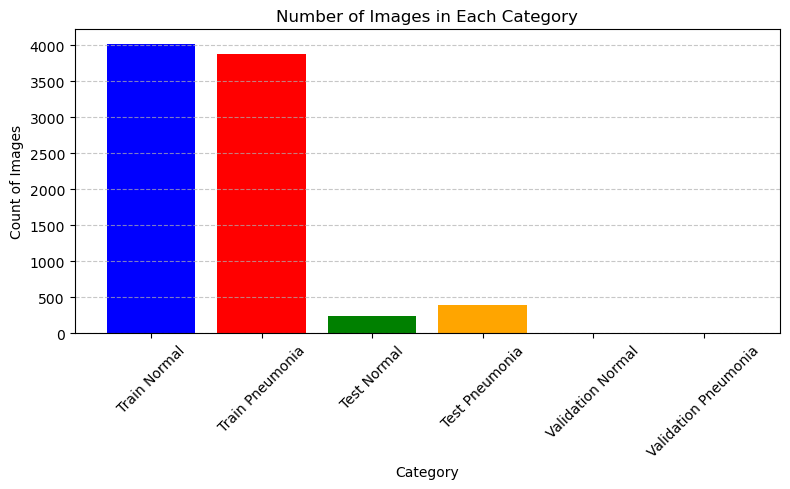

In [843]:
xray_data_distribution(dataset_path)

## Final Convolutional Network Retraining and Evaluating

Epoch 1/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Validation accuracy improved to 0.9375, model saved!
Epoch 1/10 Train Loss: 0.0286, Train Acc: 0.9904 Val Loss: 0.2062, Val Acc: 0.9375


Epoch 2/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 2/10 Train Loss: 0.0327, Train Acc: 0.9877 Val Loss: 0.4022, Val Acc: 0.8750


Epoch 3/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 3/10 Train Loss: 0.0243, Train Acc: 0.9918 Val Loss: 0.2894, Val Acc: 0.8125


Epoch 4/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 4/10 Train Loss: 0.0146, Train Acc: 0.9944 Val Loss: 1.1056, Val Acc: 0.6875


Epoch 5/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 5/10 Train Loss: 0.0159, Train Acc: 0.9939 Val Loss: 0.2433, Val Acc: 0.9375


Epoch 6/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 6/10 Train Loss: 0.0132, Train Acc: 0.9960 Val Loss: 0.7981, Val Acc: 0.6875


Epoch 7/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 7/10 Train Loss: 0.0074, Train Acc: 0.9983 Val Loss: 1.0188, Val Acc: 0.6875


Epoch 8/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 8/10 Train Loss: 0.0070, Train Acc: 0.9981 Val Loss: 0.6572, Val Acc: 0.7500


Epoch 9/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 9/10 Train Loss: 0.0059, Train Acc: 0.9985 Val Loss: 0.6448, Val Acc: 0.7500


Epoch 10/10:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 10/10 Train Loss: 0.0088, Train Acc: 0.9965 Val Loss: 0.5931, Val Acc: 0.7500
Best Validation Accuracy: 0.9375


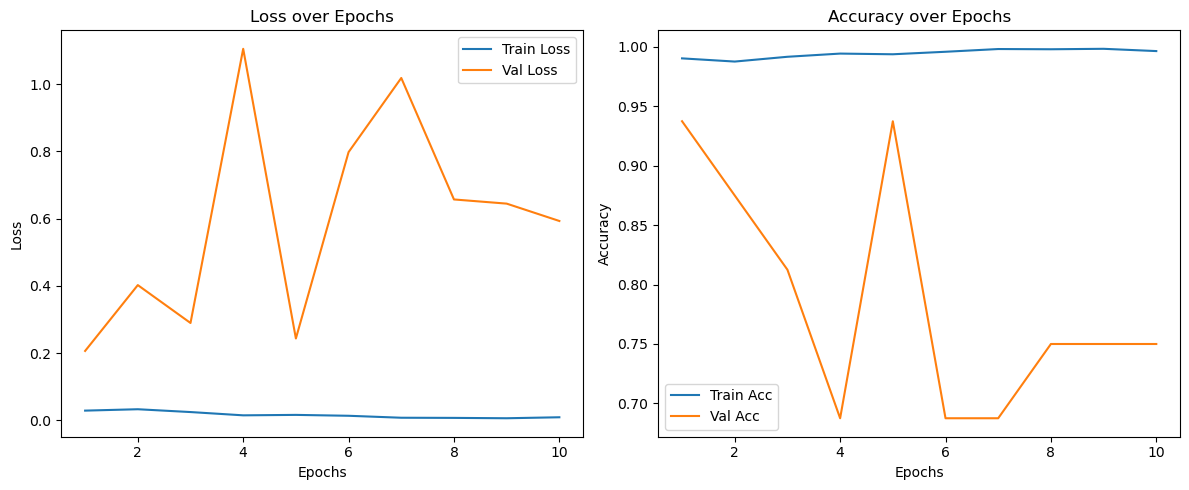

Test Loss: 5.7665, Test Accuracy: 0.7163
Reverted to the best model based on validation accuracy.
Test Loss: 1.0745, Test Accuracy: 0.7869


In [844]:
# Train the model
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
num_epochs = 10
model = train(model, train_loader, val_loader, num_epochs)

# Evaluate on test set
test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Revert model to state with best saved parameters
model = revert_to_best_model(model, "best_model.pth")

# Re-evaluate on test set
test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")